# TFM - SHAP 

Using the Shap and a CNN previously developped for Deep Learning:

+ Developing a CNN model to classify X-ray images with high accuracy.
+ To explore classifier explanation methods.

In [1]:
import numpy as np 
import pandas as pd 
import random

import os
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Multiply, Dot, Concatenate, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [3]:
def format_set(X_train, X_cv, X_test, img_width = 224, img_height = 224,grayscale = False):
    from tensorflow.keras import backend as K

    if K.image_data_format() == 'channels_first':
        if grayscale == False:      
#             input_shape = (3, img_width, img_height)
            X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
        else:
            X_train=X_train.reshape(X_train.shape[0],1,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],1,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],1,img_width,img_height)
    else:
        if grayscale == False:      
    #         input_shape = (img_width, img_height, 3)
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)
        else:
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,1)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,1)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,1)

    return X_train, X_cv, X_test

In [4]:
def gray(Im):
    '''Get greyscale images'''
    return np.dot(Im, [0.2989, 0.5870, 0.1140]) #By definition of Pillow

In [154]:
def image_load(directory, filename,sizeh = 224,sizev = 224,grayscale = False):
    '''Join directory and filename, load image, reshape to sizeh,sizev and normalize'''
    filename=os.path.join(directory, filename)
    if grayscale == False:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev)) #Full name to avoid variable interference
        im=np.reshape(im,(sizeh,sizev,3))
    else:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev),color_mode = 'grayscale')
        im=np.reshape(im,(sizeh,sizev))
    im=im.astype('float32') / 255
    return im

In [155]:
def not_super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False, grayscale = False):
    '''For labels, pass data first and label second, as a list - grayscale images are (224,224)'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            X_black = np.zeros(X.shape) #Background
            Label_black = np.zeros(X.shape) #Label background
            if grayscale == False:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
                X_black[hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:] = X_crop
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
                Label_black[hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:] = Label_crop
            else:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)]
                X_black[hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)] = X_crop
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)]
                Label_black[hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)] = Label_crop
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_black = np.flipud(X_black)
                Label_black = np.flipud(Label_black)
            images.append(X_black),labels.append(Label_black)            
        else:
            X_black = np.zeros(X.shape) #Background
            if grayscale == False:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
                X_black[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:] = X_crop
            else:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)]
                X_black[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)] = X_crop
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_black = np.flipud(X_black)
            images.append(X_black)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [169]:
def super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False, grayscale = False):
    '''For labels, pass data first and label second, as a list - grayscale images are (224,224)'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            if grayscale == False:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
            else:
                X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop)]
                Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop)]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
                Label_crop = np.flipud(Label_crop)
            images.append(X_crop),labels.append(Label_crop)            
        else:
            if grayscale == False:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
            else:
                X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop)]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
            images.append(X_crop)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [170]:
def generate_confusion_matrix(y_full_test,yhat_full_test):
    print(classification_report(y_full_test,yhat_full_test))
    C = confusion_matrix(y_full_test,yhat_full_test)
    
    # count of true negatives is [0,0], false negatives is [1,0], true positives is [1,1] and false positives is [0,1].
    TP, TN, FP, FN = C[1,1], C[0,0], C[0,1], C[1,0]
    var_name = [['TN','FP'],['FN','TP']]
    
    #Plot the confusion matrix
    
    plt.imshow(C,interpolation='nearest', cmap=plt.cm.tab20c)
    [[plt.text(i,j,var_name[i][j] +' :' + str(C[i,j]))] for i in [0,1] for j in [0,1]]
    plt.tick_params(axis='both',length=0,labelsize = 0)
    plt.axhline(0.5), plt.axvline(0.5)
    plt.show()
    
    print('accuracy is :',(TP + TN) / (TP + TN + FP + FN))
    print('F1 score is :',(2 * TP) / (2*TP + FP + FN))
    print('Miss rate is :',(FN) / (TP + FN))
    print('NPV is :',(TN) / (TN + FN))
    print('\n')
    print('Error rate :', (FP+FN)/(TP+TN+FP+FN))
    print('Sensitivity / Recall :', TP / (TP+FN))
    print('Specificity :',TN / (TN+FP))
    print('Precision :',TP / (TP+FP))
    print('False positive rate :',FP / (TN+FP))

In [158]:
def model_graphs(model,regression = False,labels = True):  
    loss_comb = model.history.history['loss']
    loss_val = model.history.history['val_loss']
    if regression == False:
        acc_comb = model.history.history['accuracy']
        acc_val = model.history.history['val_accuracy']
    else: 
        acc_comb = model.history.history['mae']
        acc_val = model.history.history['val_mae']
    epochs = np.array(model.history.epoch) + 1

    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(epochs,loss_comb)
    plt.plot(epochs,loss_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Binary crossentropy')
    else:
        plt.ylabel('Mean Squared Error')
    if labels == True:
        plt.title('Image & Label model results - Loss')
    else:
        plt.title('Image model results - Loss')
    plt.legend(['Training loss','Validation loss'])

    plt.subplot(122)
    plt.plot(epochs,acc_comb)
    plt.plot(epochs,acc_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Accuracy %')
        if labels == True:
            plt.title('Image & Label model results - Accuracy')
        else:
            plt.title('Image model results - Accuracy')
        plt.legend(['Training acc','Validation acc'])
    else:
        plt.ylabel('MAE')
        plt.title('Image & Label model results - MAE')
        plt.legend(['Training mae','Validation mae'])
    plt.show()

Download the data in a directory called `CCA2_png`.

### Dictionary with classes

In [148]:
df=pd.read_excel('imt_data.xlsx')
df.head()

,File_name,Label_file_name,ID,Side,Followup,Extension,IMT,Class,Exists?,Set_159
0,050080144_LCCAg.png,_data_CCA2_050080144_LCCAg.png,50080,LCCAg,144,.png,0.617,0,True,0
1,050080144_RCCAg.png,_data_CCA2_050080144_RCCAg.png,50080,RCCAg,144,.png,0.947,0,True,1
2,050096156_LCCAg.png,_data_CCA2_050096156_LCCAg.png,50096,LCCAg,156,.png,0.770,0,True,1
3,050096156_RCCAg.png,_data_CCA2_050096156_RCCAg.png,50096,RCCAg,156,.png,0.715,0,True,0
4,050101156_LCCAg.png,_data_CCA2_050101156_LCCAg.png,50101,LCCAg,156,.png,0.851,0,True,0


In [149]:
kv_dict= dict(zip(df['File_name'].values,df['Class'].values))
dict(list(kv_dict.items())[:8])

{'050080144_LCCAg.png': 0,
 '050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050096156_RCCAg.png': 0,
 '050101156_LCCAg.png': 0,
 '050101156_RCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0}

In [150]:
#Data with labels
df_tag = df[df['Exists?']==True]
kv_tag_dict= dict(zip(df_tag['Label_file_name'].values,df_tag['Class'].values))
dict(list(kv_tag_dict.items())[:8])

{'_data_CCA2_050080144_LCCAg.png': 0,
 '_data_CCA2_050080144_RCCAg.png': 0,
 '_data_CCA2_050096156_LCCAg.png': 0,
 '_data_CCA2_050096156_RCCAg.png': 0,
 '_data_CCA2_050101156_LCCAg.png': 0,
 '_data_CCA2_050101156_RCCAg.png': 0,
 '_data_CCA2_050194156_LCCAg.png': 0,
 '_data_CCA2_050194156_RCCAg.png': 0}

In [151]:
#Dictionary used for regression
kv_dict_imt = dict(zip(df['File_name'].values,df['IMT'].values))
dict(list(kv_dict_imt.items())[:8])

{'050080144_LCCAg.png': 0.617,
 '050080144_RCCAg.png': 0.947,
 '050096156_LCCAg.png': 0.77,
 '050096156_RCCAg.png': 0.715,
 '050101156_LCCAg.png': 0.851,
 '050101156_RCCAg.png': 0.936,
 '050194156_LCCAg.png': 0.512,
 '050194156_RCCAg.png': 0.622}

In [152]:
#Dictionary used for regression
df_set159 = df[df['Set_159']==1]
kv_dict_set159 = dict(zip(df_set159['File_name'].values,df_set159['Class'].values))
dict(list(kv_dict_set159.items())[:8])

{'050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0,
 '050247156_RCCAg.png': 0,
 '050250144_RCCAg.png': 0,
 '050260156_LCCAg.png': 0,
 '050262156_RCCAg.png': 0}

### Data augmentation

#### Create images at (200,200,3), or load the existing augmented images in the next section

In [440]:
#Plaque
kv_dict_filt1 = {key:value for (key,value) in kv_dict.items() if value==1} #Get a dictionary with only the images with plaque
kv_dict_filt1_cv = dict(random.sample(list(kv_dict_filt1.items()),20)) #CV set
kv_dict_filt1_test = dict(random.sample(list(kv_dict_filt1_cv.items()),10)) #Test set
kv_dict_filt1_val = {key:value for (key,value) in kv_dict_filt1_cv.items() if key not in kv_dict_filt1_test.keys()} #Validation set
kv_dict_filt1_train = {key:value for (key,value) in kv_dict_filt1.items() if key not in kv_dict_filt1_cv.keys()} #Train set

#Non plaque
kv_dict_filt2 = {key:value for (key,value) in kv_dict.items() if value==0} #Get a dictionary with only the no plaque images
kv_dict_filt2_all = dict(random.sample(list(kv_dict_filt2.items()),3000)) #Random images from set
kv_dict_filt2_cv = dict(random.sample(list(kv_dict_filt2_all.items()),1000)) #CV set
kv_dict_filt2_test = dict(random.sample(list(kv_dict_filt2_cv.items()),500)) #Test set
kv_dict_filt2_val = {key:value for (key,value) in kv_dict_filt2_cv.items() if key not in kv_dict_filt2_test.keys()} #Validation set
kv_dict_filt2_train = {key:value for (key,value) in kv_dict_filt2_all.items() if key not in kv_dict_filt2_cv.keys()} #Train set


In [441]:
#Create new images from images with plaque & modify the old ones to be smaller
Full_train = []
Full_test = []
Full_val = []
Full_label_train = []
Full_label_test = []
Full_label_val = []

directory_file = 'CCA2_png'

#NON PLAQUE
counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if ((filename in kv_dict_filt2_train or filename in kv_dict_filt2_test or filename in kv_dict_filt2_val) 
    and (filename.endswith(".png") or filename.endswith(".jpg"))): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        #Apply transformation to orginal images
        d = super_cropper(im_data,hcrop=19,vcrop=19,generate = 1)[0]
        if filename in kv_dict_filt2_train:
            Full_train.append(d.astype('float32'))
            Full_label_train.append(kv_dict.get(filename))
            plt.imsave('./NEW_CCA2_png_augmented/Train/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        elif filename in kv_dict_filt2_test:
            Full_test.append(d.astype('float32'))
            Full_label_test.append(kv_dict.get(filename))
            plt.imsave('./NEW_CCA2_png_augmented/Test/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        else:
            Full_val.append(d.astype('float32'))
            Full_label_val.append(kv_dict.get(filename))
            plt.imsave('./NEW_CCA2_png_augmented/Validation/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                label = kv_dict.get(filename)),d)
        counter+=1

#PLAQUE IMAGES
counter = 0
generate_nb = 10
k = 5 # High number will create memory errors for the arrays, normally >10,000 images

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_train) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,hcrop=19,vcrop=19,generate = generate_nb)
            for image in d:
                Full_train.append(image.astype('float32'))
                Full_label_train.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_png_augmented/Train/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_test) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,generate = generate_nb)
            for image in d:
                Full_test.append(image.astype('float32'))
                Full_label_test.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_png_augmented/Test/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_val) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d = super_cropper(im_data,generate = generate_nb)
            for image in d:
                Full_val.append(image.astype('float32'))
                Full_label_val.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_png_augmented/Validation/new_image{counter}_1.png'.format(counter = counter),image)
                counter+=1
        else:
            continue

### Load existing

In [ ]:
directory_file_train = 'NEW_CCA2_png_augmented/Train'
directory_file_val = 'NEW_CCA2_png_augmented/Validation'
directory_file_test = 'NEW_CCA2_png_augmented/Test'

Full_train = []
Full_test = []
Full_val = []

Full_label_train = []
Full_label_test = []
Full_label_val = []

#Original images
for filename in tqdm_notebook(os.listdir(directory_file_train)) :
    im_data = image_load(directory_file_train, filename, sizeh = 205, sizev = 205)        
    Full_train_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_train.append(np.int64(1))
    else:
        Full_label_train.append(np.int64(0))

for filename in tqdm_notebook(os.listdir(directory_file_val)) :
    im_data = image_load(directory_file_val, filename, sizeh = 205, sizev = 205)        
    Full_val_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_val.append(np.int64(1))
    else:
        Full_label_val.append(np.int64(0))

for filename in tqdm_notebook(os.listdir(directory_file_test)) :
    im_data = image_load(directory_file_test, filename, sizeh = 205, sizev = 205)        
    Full_test_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_test.append(np.int64(1))
    else:
        Full_label_test.append(np.int64(0))


In [442]:
print(len(Full_train)), print(len(Full_val)), print(len(Full_test))
print(sum(Full_label_train)),print(sum(Full_label_val)),print(sum(Full_label_test))
sum(Full_label_train) / len(Full_train) #Share of plaque 

4000
1000
1000
2000
500
500


0.5

In [443]:
X_full_train, X_full_cv, X_full_test = np.array(Full_train), np.array(Full_val), np.array(Full_test)

In [444]:
#GT definition
y_full_train, y_full_cv, y_full_test = np.array(Full_label_train), np.array(Full_label_val), np.array(Full_label_test)

In [445]:
X_full_train, X_full_cv, X_full_test = format_set(X_full_train, X_full_cv, X_full_test,img_width = 205,img_height = 205)

In [446]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model_single = Sequential(name = 'Full_data_model')

#Add max pooling layers for each convolution, and then pass the results through a dense layer, and output with a sigmoid

model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X_full_train.shape[1:]))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

model_single.add(Dropout(0.25)) #Avoid overfitting
model_single.add(Flatten()) # this converts the 3D feature maps to 1D feature vectors

model_single.add(Dense(128, activation='relu'))
model_single.add(Dropout(0.5)) #Avoid overfitting
model_single.add(Dense(1, activation='sigmoid'))

model_single.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single.summary()

Model: "Full_data_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 203, 203, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 99, 99, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 21, 21, 32)    

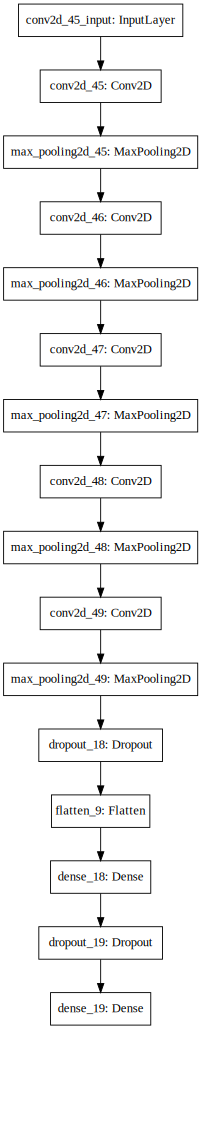

In [447]:
SVG(model_to_dot(model_single, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [448]:
model_single.fit(X_full_train, y_full_train, batch_size=128, epochs=15, verbose=1,validation_data=(X_full_cv, y_full_cv))

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - ETA: 4:18 - loss: 0.6928 - accuracy: 0.48 - ETA: 2:53 - loss: 0.6914 - accuracy: 0.53 - ETA: 2:21 - loss: 0.6896 - accuracy: 0.53 - ETA: 2:06 - loss: 0.6921 - accuracy: 0.51 - ETA: 1:55 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:47 - loss: 0.6952 - accuracy: 0.49 - ETA: 1:39 - loss: 0.6958 - accuracy: 0.48 - ETA: 1:32 - loss: 0.6956 - accuracy: 0.49 - ETA: 1:26 - loss: 0.6948 - accuracy: 0.49 - ETA: 1:21 - loss: 0.6944 - accuracy: 0.50 - ETA: 1:16 - loss: 0.6935 - accuracy: 0.50 - ETA: 1:11 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:07 - loss: 0.6922 - accuracy: 0.51 - ETA: 1:03 - loss: 0.6919 - accuracy: 0.51 - ETA: 58s - loss: 0.6914 - accuracy: 0.5188 - ETA: 54s - loss: 0.6905 - accuracy: 0.525 - ETA: 50s - loss: 0.6905 - accuracy: 0.526 - ETA: 47s - loss: 0.6899 - accuracy: 0.527 - ETA: 43s - loss: 0.6900 - accuracy: 0.528 - ETA: 39s - loss: 0.6884 - accuracy: 0.533 - ETA: 35s - loss

4000/4000 [==============================] - ETA: 2:06 - loss: 0.1303 - accuracy: 0.93 - ETA: 2:02 - loss: 0.1012 - accuracy: 0.95 - ETA: 1:57 - loss: 0.0952 - accuracy: 0.95 - ETA: 1:47 - loss: 0.0829 - accuracy: 0.96 - ETA: 1:39 - loss: 0.0825 - accuracy: 0.96 - ETA: 1:33 - loss: 0.1007 - accuracy: 0.96 - ETA: 1:28 - loss: 0.1028 - accuracy: 0.96 - ETA: 1:24 - loss: 0.1007 - accuracy: 0.96 - ETA: 1:19 - loss: 0.0974 - accuracy: 0.96 - ETA: 1:14 - loss: 0.1014 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1032 - accuracy: 0.96 - ETA: 1:06 - loss: 0.1041 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1004 - accuracy: 0.96 - ETA: 59s - loss: 0.0977 - accuracy: 0.9637 - ETA: 57s - loss: 0.1012 - accuracy: 0.962 - ETA: 53s - loss: 0.1022 - accuracy: 0.962 - ETA: 49s - loss: 0.1026 - accuracy: 0.961 - ETA: 46s - loss: 0.1018 - accuracy: 0.963 - ETA: 42s - loss: 0.1031 - accuracy: 0.961 - ETA: 38s - loss: 0.1042 - accuracy: 0.961 - ETA: 35s - loss: 0.1058 - accuracy: 0.960 - ETA: 31s - loss: 0.1070 - accu

In [449]:
test_score, test_acc = model_single.evaluate(X_full_test,y_full_test)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 13s 13ms/sample - loss: 2.1859 - accuracy: 0.8200


In [450]:
print('Test accuracy is:', test_acc)
print('Test score is :', test_score)

Test accuracy is: 0.82
Test score is : 0.6330330874323845


In [451]:
#Output the classes (0 or 1) rather than the probabilities for the confusion matrix
yhat_full_test = model_single.predict_classes(X_full_test)
yhat_full_test_pred = model_single.predict(X_full_test) #Get the probabilities in case

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       500
           1       0.90      0.72      0.80       500

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000



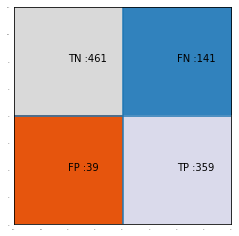

accuracy is : 0.82
F1 score is : 0.799554565701559
Miss rate is : 0.282
NPV is : 0.7657807308970099


Error rate : 0.18
Sensitivity / Recall : 0.718
Specificity : 0.922
Precision : 0.9020100502512562
False positive rate : 0.078


In [452]:
generate_confusion_matrix(y_full_test,yhat_full_test)

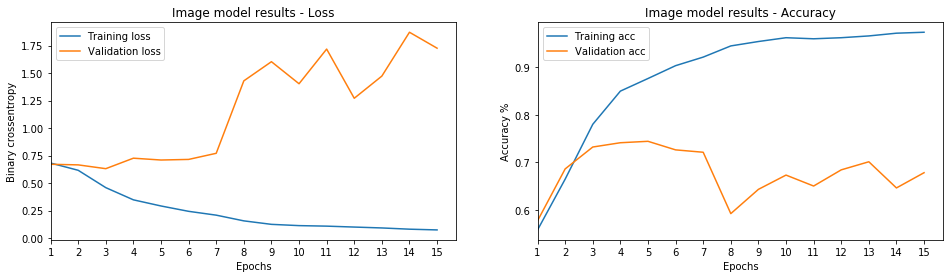

In [453]:
model_graphs(model_single,labels = False)

In [454]:
# model_single.save('./Models/NEW_model_single.h5')
# model_single = tf.keras.models.load_model('./Models/NEW_model_single.h5')

## SHAP

SHAP (SHapley Additive exPlanations) (https://github.com/slundberg/shap) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.


In [457]:
background = X_full_train[np.random.choice(X_full_train.shape[0], 200, replace=False)]

# explain predictions of the model on several images
e = shap.GradientExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version
# e = shap.DeepExplainer(model_single, background) #Deep Explainer doesn't work yet for tf 2.0, need to use older version


In [458]:
idx = np.arange(len(X_full_test))
np.random.shuffle(idx)

In [459]:
X_full_test = X_full_test[idx]
yhat_full_test = yhat_full_test[idx]
y_full_test = y_full_test[idx]

B = np.block([yhat_full_test,y_full_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([ 13,  18,  22,  27,  41,  74,  80,  84,  88,  93,  99, 101, 104,
       105, 106, 109, 110, 112, 117, 122, 125, 126, 127, 131, 137, 161,
       168, 173, 174, 181, 185, 191, 192, 194, 200, 213, 216, 218, 226,
       229, 234, 238, 253, 259, 266, 269, 274, 275, 282, 290, 292, 294,
       301, 302, 303, 307, 312, 335, 348, 352, 354, 359, 361, 369, 376,
       379, 381, 398, 401, 402, 403, 414, 423, 424, 429, 441, 443, 447,
       448, 454, 459, 461, 466, 482, 489, 492, 503, 514, 517, 522, 530,
       543, 552, 555, 566, 575, 578, 588, 590, 593, 603, 604, 608, 615,
       624, 626, 627, 630, 636, 642, 646, 653, 655, 658, 661, 664, 670,
       672, 683, 692, 701, 702, 708, 709, 710, 727, 733, 734, 738, 741,
       746, 753, 754, 757, 761, 771, 772, 776, 781, 784, 788, 791, 797,
       826, 830, 842, 843, 844, 848, 866, 871, 872, 877, 879, 887, 888,
       891, 893, 897, 913, 917, 931, 934, 938, 947, 954, 961, 965, 974,
       976, 979, 981, 986, 987, 988, 990, 992, 997, 998, 999], d

In [460]:
start = 22
end = 28

In [461]:
print(yhat_full_test[start:end].ravel())
print(y_full_test[start:end])

[0 0 0 1 0 0]
[1 0 0 1 0 1]


In [462]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_full_test[start:end])

In [463]:
labels = y_full_test[start:end] + yhat_full_test[start:end].ravel()/10
labels

array([1. , 0. , 0. , 1.1, 0. , 1. ])

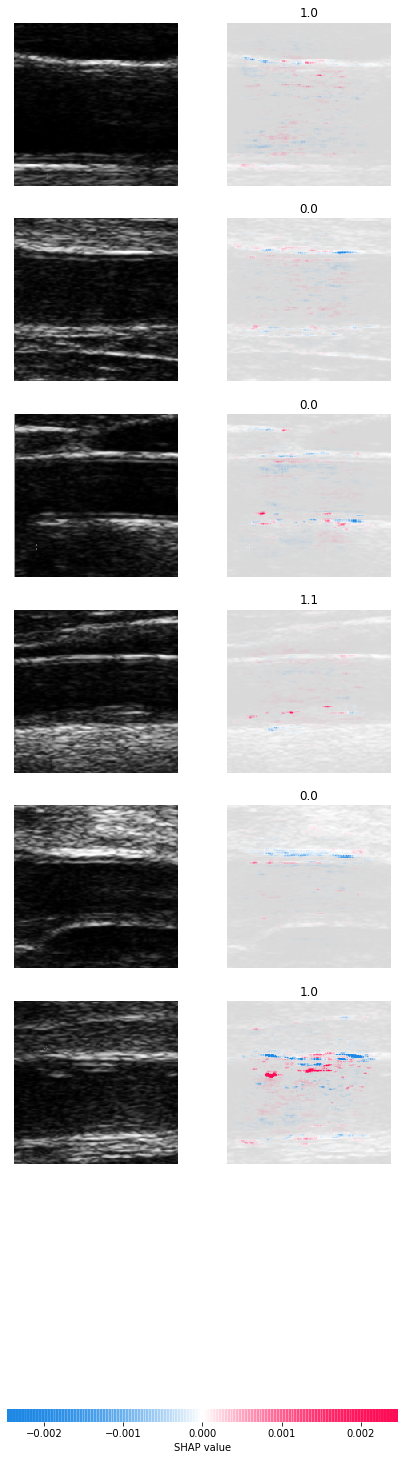

In [464]:
#Correct is first, predicted is second
shap.image_plot(shap_values, X_full_test[start:end],labels = labels[:,np.newaxis],show = False)
fig = plt.gcf()
fig.set_size_inches((7, 30))

### With image and label

In [120]:
#Plaque - taking out '_data_CCA2_' (11 characters)
kv_dict_filt1 = {key[11:]:value for (key,value) in kv_tag_dict.items() if value==1} #Get a dictionary with only the images with plaque
kv_dict_filt1_cv = dict(random.sample(list(kv_dict_filt1.items()),15)) #CV set
kv_dict_filt1_test = dict(random.sample(list(kv_dict_filt1_cv.items()),5)) #Test set
kv_dict_filt1_val = {key:value for (key,value) in kv_dict_filt1_cv.items() if key not in kv_dict_filt1_test.keys()} #Validation set
kv_dict_filt1_train = {key:value for (key,value) in kv_dict_filt1.items() if key not in kv_dict_filt1_cv.keys()} #Train set

#Non plaque - taking out '_data_CCA2_' (11 characters)
kv_dict_filt2 = {key[11:]:value for (key,value) in kv_tag_dict.items() if value==0} #Get a dictionary with only the no plaque images
kv_dict_filt2_all = dict(random.sample(list(kv_dict_filt2.items()),2900)) #Random images from set
kv_dict_filt2_cv = dict(random.sample(list(kv_dict_filt2_all.items()),750)) #CV set
kv_dict_filt2_test = dict(random.sample(list(kv_dict_filt2_cv.items()),250)) #Test set
kv_dict_filt2_val = {key:value for (key,value) in kv_dict_filt2_cv.items() if key not in kv_dict_filt2_test.keys()} #Validation set
kv_dict_filt2_train = {key:value for (key,value) in kv_dict_filt2_all.items() if key not in kv_dict_filt2_cv.keys()} #Train set


In [146]:
#Create new images from images with plaque & modify the old ones to be smaller
Full_train_org = []
Full_test_org = []
Full_val_org = []
Full_train_tag = []
Full_test_tag = []
Full_val_tag = []

Full_label_train = []
Full_label_test = []
Full_label_val = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

#NON PLAQUE
counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if ((filename in kv_dict_filt2_train or filename in kv_dict_filt2_test or filename in kv_dict_filt2_val) 
        and (filename.endswith(".png") or filename.endswith(".jpg"))):
        
        #Apply transformation to orginal images
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
        
        #Apply the cropper to the loaded images
        d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
        
        if filename in kv_dict_filt2_train: 
            Full_train_org.append(d[0].astype('float32'))
            Full_label_train.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
            plt.imsave('./NEW_CCA2_2_augmented/Train/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                  label = kv_dict.get(filename)),d[0])
            #Save the label images as well, though the class is the same, so no need to add it twice
            Full_train_tag.append(l[0].astype('float32'))
            plt.imsave('./NEW_CCA2_2_labels_augmented/Train/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])
        if filename in kv_dict_filt2_test: 
            Full_test_org.append(d[0].astype('float32'))
            Full_label_test.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
            plt.imsave('./NEW_CCA2_2_augmented/Test/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                  label = kv_dict.get(filename)),d[0])
            #Save the label images as well, though the class is the same, so no need to add it twice
            Full_test_tag.append(l[0].astype('float32'))
            plt.imsave('./NEW_CCA2_2_labels_augmented/Test/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])

        if filename in kv_dict_filt2_val: 
            Full_val_org.append(d[0].astype('float32'))
            Full_label_val.append(kv_dict.get(filename)) #Get the 0 or 1 indications from one of the dictionaries
            plt.imsave('./NEW_CCA2_2_augmented/Validation/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                  label = kv_dict.get(filename)),d[0])
            #Save the label images as well, though the class is the same, so no need to add it twice
            Full_val_tag.append(l[0].astype('float32'))
            plt.imsave('./NEW_CCA2_2_labels_augmented/Validation/old_image{counter}_{label}.png'.format(counter = counter,
                                                                                     label = kv_dict.get(filename)),l[0])
        counter+=1

#PLAQUE IMAGES
counter = 0
generate_nb = 10
k = 5 # High number will create memory errors for the arrays, normally >10,000 images

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_train) :        
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True)
            for image,label in zip(d,l):
                Full_train_org.append(image.astype('float32'))
                Full_label_train.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_2_augmented/Train/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_train_tag.append(label.astype('float32'))
                plt.imsave('./NEW_CCA2_2_labels_augmented/Train/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_test) :        
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True)
            for image,label in zip(d,l):
                Full_test_org.append(image.astype('float32'))
                Full_label_test.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_2_augmented/Test/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_test_tag.append(label.astype('float32'))
                plt.imsave('./NEW_CCA2_2_labels_augmented/Test/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue

for i in range(k):
    for filename in tqdm_notebook(kv_dict_filt1_val) :
        if filename.endswith(".png"): 
            im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
            im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
            
            #Apply the cropper to the loaded images
            d,l = super_cropper([im_data,im_label],generate = generate_nb,use_list = True)
            for image,label in zip(d,l):
                Full_val_org.append(image.astype('float32'))
                Full_label_val.append(np.int64(1)) #All images created are "plaque"
                plt.imsave('./NEW_CCA2_2_augmented/Validation/new_image{counter}_1.png'.format(counter = counter),image)
                
                Full_val_tag.append(label.astype('float32'))
                plt.imsave('./NEW_CCA2_2_labels_augmented/Validation/new_image{counter}_1.png'.format(counter = counter),label)
                counter+=1
        else:
            continue


### Load existing

In [414]:
directory_file_train = 'NEW_CCA2_2_augmented/Train'
directory_file_val = 'NEW_CCA2_2_augmented/Validation'
directory_file_test = 'NEW_CCA2_2_augmented/Test'

directory_tag_train = 'NEW_CCA2_2_labels_augmented/Train'
directory_tag_val = 'NEW_CCA2_2_labels_augmented/Validation'
directory_tag_test = 'NEW_CCA2_2_labels_augmented/Test'

Full_train_org = []
Full_test_org = []
Full_val_org = []

Full_train_tag = []
Full_test_tag = []
Full_val_tag = []

Full_label_train = []
Full_label_test = []
Full_label_val = []

#Original images
for filename in tqdm_notebook(os.listdir(directory_file_train)) :
    im_data = image_load(directory_file_train, filename, sizeh = 205, sizev = 205)        
    Full_train_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_train.append(np.int64(1))
    else:
        Full_label_train.append(np.int64(0))

for filename in tqdm_notebook(os.listdir(directory_file_val)) :
    im_data = image_load(directory_file_val, filename, sizeh = 205, sizev = 205)        
    Full_val_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_val.append(np.int64(1))
    else:
        Full_label_val.append(np.int64(0))

for filename in tqdm_notebook(os.listdir(directory_file_test)) :
    im_data = image_load(directory_file_test, filename, sizeh = 205, sizev = 205)        
    Full_test_org.append(im_data.astype('float32'))
    if filename.endswith('1.png'):
        Full_label_test.append(np.int64(1))
    else:
        Full_label_test.append(np.int64(0))

#Tags
for filename in tqdm_notebook(os.listdir(directory_tag_train)) :
    im_data = image_load(directory_tag_train, filename, sizeh = 205, sizev = 205)        
    Full_train_tag.append(im_data.astype('float32'))

for filename in tqdm_notebook(os.listdir(directory_tag_val)) :
    im_data = image_load(directory_tag_val, filename, sizeh = 205, sizev = 205)        
    Full_val_tag.append(im_data.astype('float32'))

for filename in tqdm_notebook(os.listdir(directory_tag_test)) :
    im_data = image_load(directory_tag_test, filename, sizeh = 205, sizev = 205)        
    Full_test_tag.append(im_data.astype('float32'))


In [415]:
print(len(Full_train_org)), print(len(Full_train_tag))
print(len(Full_test_org)), print(len(Full_test_tag))
print(len(Full_val_org)), print(len(Full_val_tag))
print(sum(Full_label_train)), print(sum(Full_label_val)), print(sum(Full_label_test))
sum(Full_label_train) / len(Full_train_org) #Share of plaque

4300
4300
500
500
1000
1000
2150
500
250


0.5

In [416]:
#Train Test Split
X_train_org, X_cv_org, X_test_org = np.array(Full_train_org), np.array(Full_val_org), np.array(Full_test_org)
X_train_tag, X_cv_tag, X_test_tag = np.array(Full_train_tag), np.array(Full_val_tag), np.array(Full_test_tag)

y_train, y_cv, y_test = np.array(Full_label_train), np.array(Full_label_val), np.array(Full_label_test)


In [417]:
X_train_org, X_cv_org, X_test_org = format_set(X_train_org, X_cv_org, X_test_org,img_width = 205,img_height=205)
X_train_tag, X_cv_tag, X_test_tag = format_set(X_train_tag, X_cv_tag, X_test_tag,img_width = 205,img_height=205)

In [127]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org,X_train_tag]

#BatchNormlization layers cause the model to seriously overfit
original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting
main_output = Dense(1, activation='sigmoid')(x)

model_combo = Model(inputs=[original_input, tagged_input], outputs=[main_output])
model_combo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_combo.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 205, 205, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 203, 203, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 203, 203, 32) 896         input_2[0][0]                    
______________________________________________________________________________________________

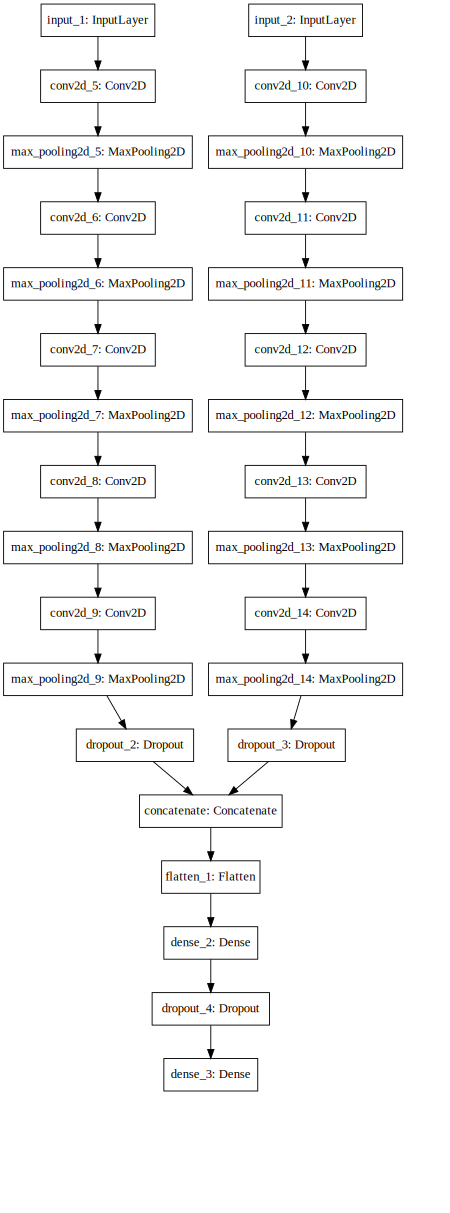

In [128]:
SVG(model_to_dot(model_combo, dpi = 65).create(prog='dot', format='svg'))

In [129]:
model_combo.fit([X_train_org,X_train_tag], y_train, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org,X_cv_tag], y_cv))

Train on 4300 samples, validate on 1000 samples
Epoch 1/15
4300/4300 [==============================] - ETA: 13:34 - loss: 0.7126 - accuracy: 0.406 - ETA: 8:02 - loss: 0.7014 - accuracy: 0.480 - ETA: 6:03 - loss: 0.6981 - accuracy: 0.48 - ETA: 4:53 - loss: 0.6959 - accuracy: 0.49 - ETA: 4:09 - loss: 0.6937 - accuracy: 0.49 - ETA: 3:38 - loss: 0.6916 - accuracy: 0.50 - ETA: 3:15 - loss: 0.6883 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6851 - accuracy: 0.53 - ETA: 2:42 - loss: 0.6811 - accuracy: 0.55 - ETA: 2:29 - loss: 0.6779 - accuracy: 0.56 - ETA: 2:18 - loss: 0.6704 - accuracy: 0.58 - ETA: 2:08 - loss: 0.6638 - accuracy: 0.59 - ETA: 1:59 - loss: 0.6574 - accuracy: 0.59 - ETA: 1:51 - loss: 0.6475 - accuracy: 0.61 - ETA: 1:43 - loss: 0.6401 - accuracy: 0.61 - ETA: 1:36 - loss: 0.6307 - accuracy: 0.63 - ETA: 1:29 - loss: 0.6199 - accuracy: 0.64 - ETA: 1:22 - loss: 0.6096 - accuracy: 0.65 - ETA: 1:16 - loss: 0.5986 - accuracy: 0.66 - ETA: 1:10 - loss: 0.5865 - accuracy: 0.67 - ETA: 1:04 - l

4300/4300 [==============================] - ETA: 2:06 - loss: 0.0779 - accuracy: 0.96 - ETA: 2:02 - loss: 0.0660 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0491 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0457 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0393 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0465 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0416 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0391 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0383 - accuracy: 0.98 - ETA: 1:25 - loss: 0.0448 - accuracy: 0.98 - ETA: 1:21 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0428 - accuracy: 0.98 - ETA: 1:13 - loss: 0.0437 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0479 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0483 - accuracy: 0.98 - ETA: 1:01 - loss: 0.0555 - accuracy: 0.98 - ETA: 57s - loss: 0.0538 - accuracy: 0.9840 - ETA: 53s - loss: 0.0535 - accuracy: 0.983 - ETA: 49s - loss: 0.0516 - accuracy: 0.984 - ETA: 45s - loss: 0.0527 - accu

In [130]:
test_score2, test_acc2 = model_combo.evaluate([X_test_org,X_test_tag],y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 7s 15ms/sample - loss: 0.4810 - accuracy: 0.8980


In [131]:
print('Test accuracy is:', test_acc2)
print('Test score is :', test_score2)

Test accuracy is: 0.898
Test score is : 0.3049338979928289


In [418]:
yhat_test_pred = model_combo.predict([X_test_org,X_test_tag]) #predict_classes doesn't work for non sequential, returns % chance
yhat_test = np.around(yhat_test_pred).flatten().astype(int) #Round to 0 or 1 depending on prediction

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       250
           1       0.95      0.84      0.89       250

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



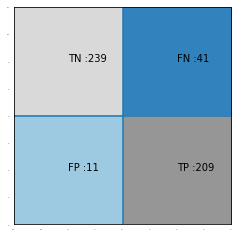

accuracy is : 0.896
F1 score is : 0.8893617021276595
Miss rate is : 0.164
NPV is : 0.8535714285714285


Error rate : 0.104
Sensitivity / Recall : 0.836
Specificity : 0.956
Precision : 0.95
False positive rate : 0.044


In [419]:
generate_confusion_matrix(y_test,yhat_test)

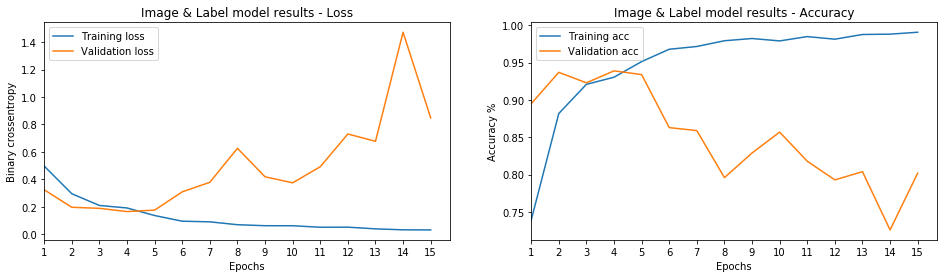

In [134]:
model_graphs(model_combo)

In [370]:
# model_combo.save('./Models/NEW_model_combo.h5')
model_combo = tf.keras.models.load_model('./Models/NEW_model_combo.h5')

In [455]:
idx = np.arange(len(yhat_test))
np.random.shuffle(idx)

In [421]:
randomizer = np.random.choice(X_train_tag.shape[0], 200, replace=False)
background = [X_train_org[randomizer],X_train_tag[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_combo, background) #Deep Explainer doesn't work yet for tf 2.0

In [422]:
X_test_org = X_test_org[idx]
X_test_tag = X_test_tag[idx]
yhat_test = yhat_test[idx]
y_test = y_test[idx]

B = np.block([yhat_test[:,np.newaxis],y_test[:,np.newaxis]])
np.where(np.sum(B,axis=1) == 1 )[0] #Get misclassifications

array([  2,   6,  16,  19,  40,  49,  50,  52,  53,  70,  79,  89,  93,
       115, 116, 129, 155, 156, 157, 176, 188, 210, 211, 239, 241, 244,
       247, 252, 261, 264, 266, 268, 269, 270, 290, 317, 322, 325, 330,
       349, 352, 362, 367, 374, 379, 390, 405, 437, 438, 459, 473, 497],
      dtype=int64)

In [434]:
start = 1
end = 8

In [435]:
print(yhat_test[start:end])
print(y_test[start:end])

[0 1 0 1 0 0 1]
[0 0 0 1 0 1 1]


In [436]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org[start:end],X_test_tag[start:end]])
labels_org = y_test[start:end] + yhat_test[start:end]/10
labels_org

array([0. , 0.1, 0. , 1.1, 0. , 1. , 1.1])

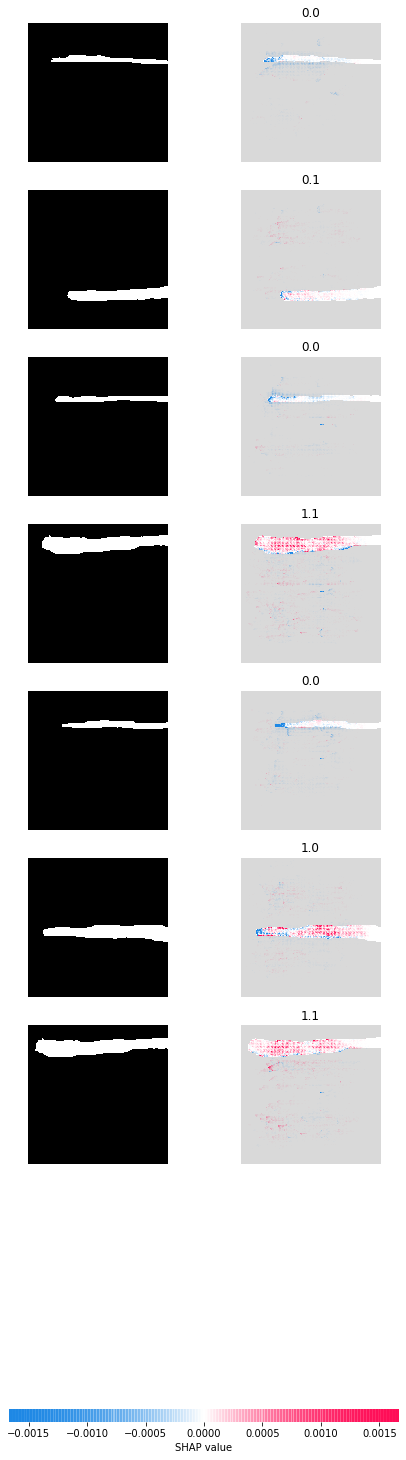

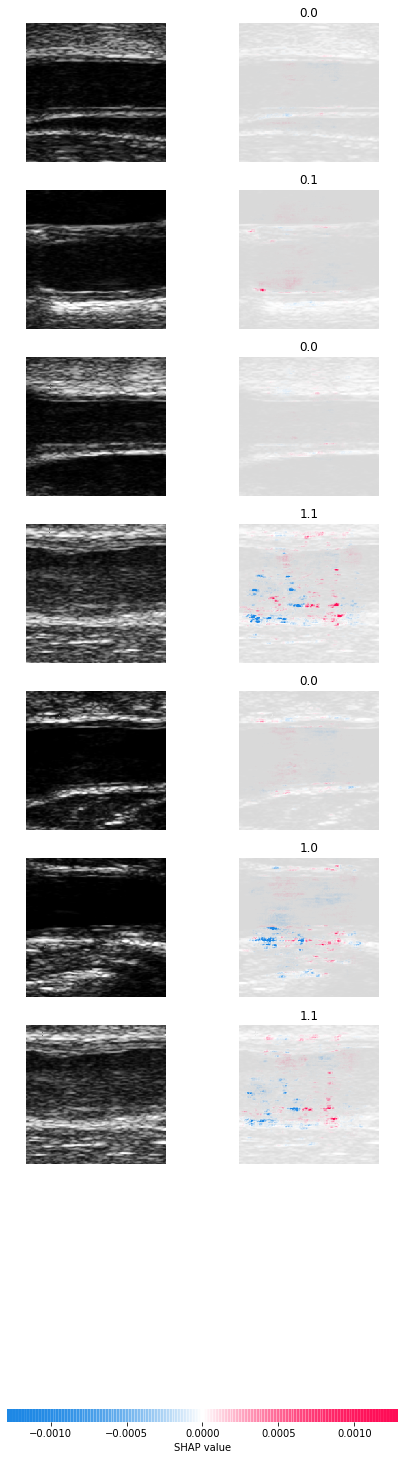

In [437]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag[start:end],labels = labels_org[:,np.newaxis],show=False) #Tag
fig = plt.gcf()
fig.set_size_inches((7, 30),forward = True)

shap.image_plot([shap_values[0][0]], X_test_org[start:end],labels = labels_org[:,np.newaxis],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((7, 30))